Import backtester

In [1]:
import importlib.util
import sys
import os

# Path to backtester.py
backtester_path = "backtester.py"
spec = importlib.util.spec_from_file_location("backtester", backtester_path)
backtester = importlib.util.module_from_spec(spec)
sys.modules["backtester"] = backtester
spec.loader.exec_module(backtester)

Code

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

# Strategy constants
LOOKBACK_WINDOW = 30
RETRAIN_INTERVAL = 50
INSTRUMENT_POSITION_LIMIT = 10000

# Model cache
model_state = {
    "last_trained": -RETRAIN_INTERVAL,
    "model": None
}

# --- Feature Engineering ---
def compute_features(prices: np.ndarray) -> np.ndarray:
    """
    prices: shape (window,)
    returns: shape (window, 3) — [price, log return, EMA]
    """
    price_series = pd.Series(prices)
    log_returns = price_series.pct_change().fillna(0).values
    ema = price_series.ewm(span=10, adjust=False).mean().bfill().values
    return np.stack([prices, log_returns, ema], axis=1)

# --- LSTM Architecture ---
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(32, return_sequences=False),
        Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Main Strategy Logic ---
def getMyPosition(prcSoFar: np.ndarray) -> np.ndarray:
    global model_state
    n_assets, n_days = prcSoFar.shape
    positions = np.zeros(n_assets)

    # Not enough data to proceed
    if n_days < LOOKBACK_WINDOW + RETRAIN_INTERVAL + 5:
        return positions

    # Retrain if enough time has passed
    if n_days - model_state["last_trained"] >= RETRAIN_INTERVAL:
        model_state["last_trained"] = n_days
        X = []
        y = []

        for i in range(n_assets):
            for t in range(n_days - LOOKBACK_WINDOW - 5):
                end_idx = t + LOOKBACK_WINDOW
                future_idx = end_idx + 5

                if future_idx >= n_days:
                    continue

                window = prcSoFar[i, t:end_idx]
                features = compute_features(window)
                X.append(features)

                future_return = prcSoFar[i, future_idx] - prcSoFar[i, end_idx - 1]
                y.append(1 if future_return > 0 else -1)

        X = np.array(X)  # shape: (samples, window, 3)
        y = np.array(y)

        model = build_lstm_model(X.shape[1:])
        model.fit(X, y, epochs=10, verbose=0, batch_size=32)
        model_state["model"] = model

    # Predict positions for today
    X_pred = []
    for i in range(n_assets):
        window = prcSoFar[i, -LOOKBACK_WINDOW:]
        features = compute_features(window)
        X_pred.append(features)

    X_pred = np.array(X_pred)  # shape: (n_assets, window, 3)
    signals = model_state["model"].predict(X_pred, verbose=0).flatten()

    for i in range(n_assets):
        dollar_alloc = INSTRUMENT_POSITION_LIMIT * signals[i]
        positions[i] = dollar_alloc / prcSoFar[i, -1]

    return np.clip(positions, -INSTRUMENT_POSITION_LIMIT / prcSoFar[:, -1],
                   INSTRUMENT_POSITION_LIMIT / prcSoFar[:, -1])

Running backtester

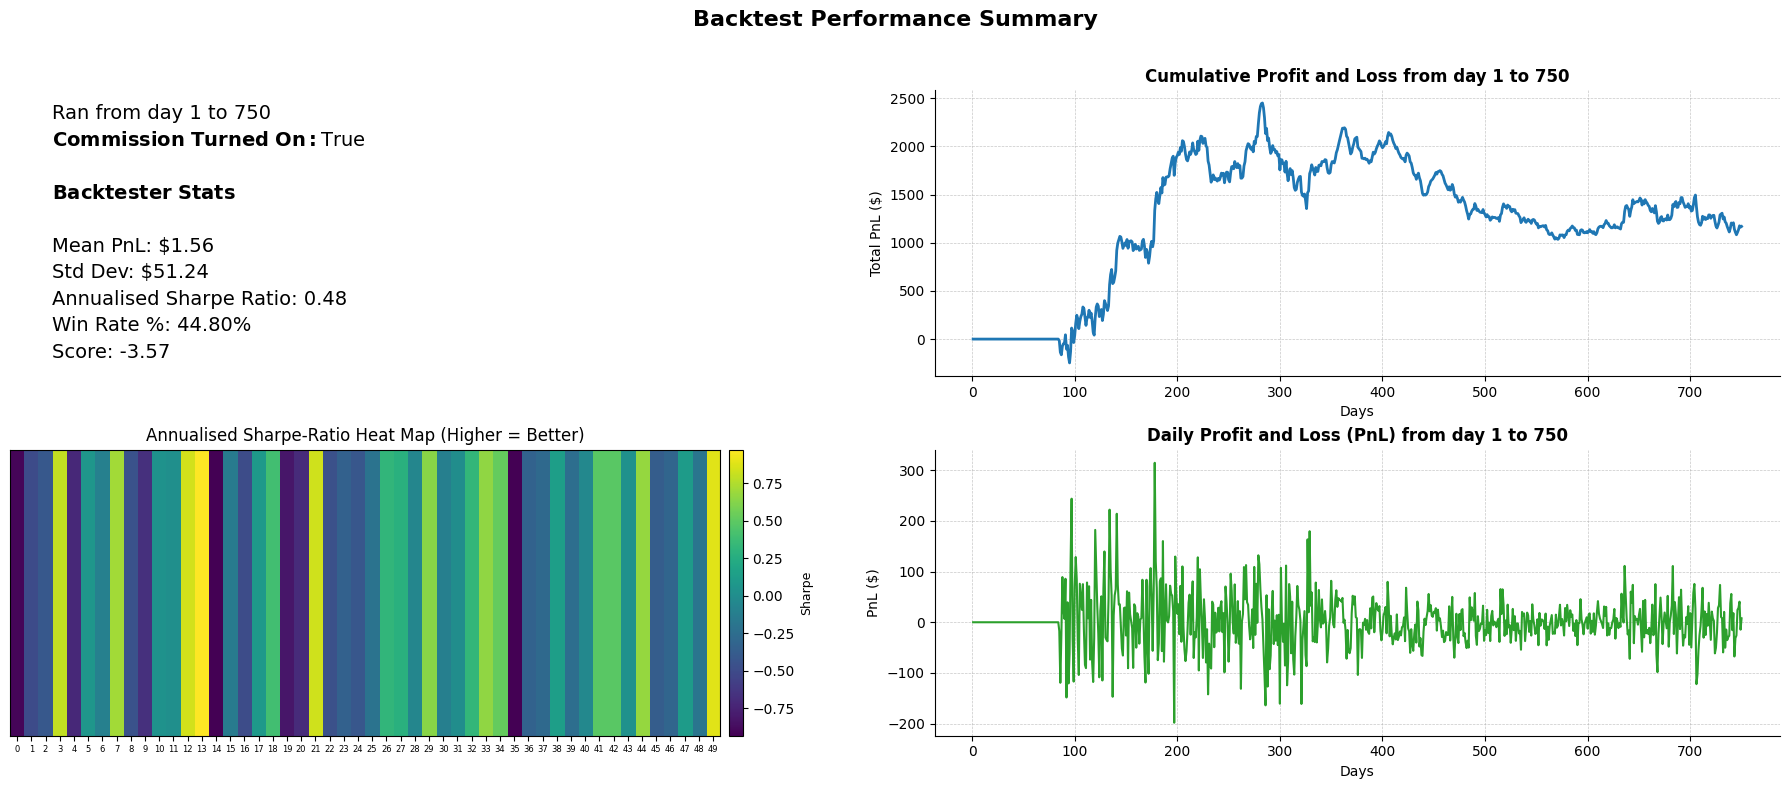

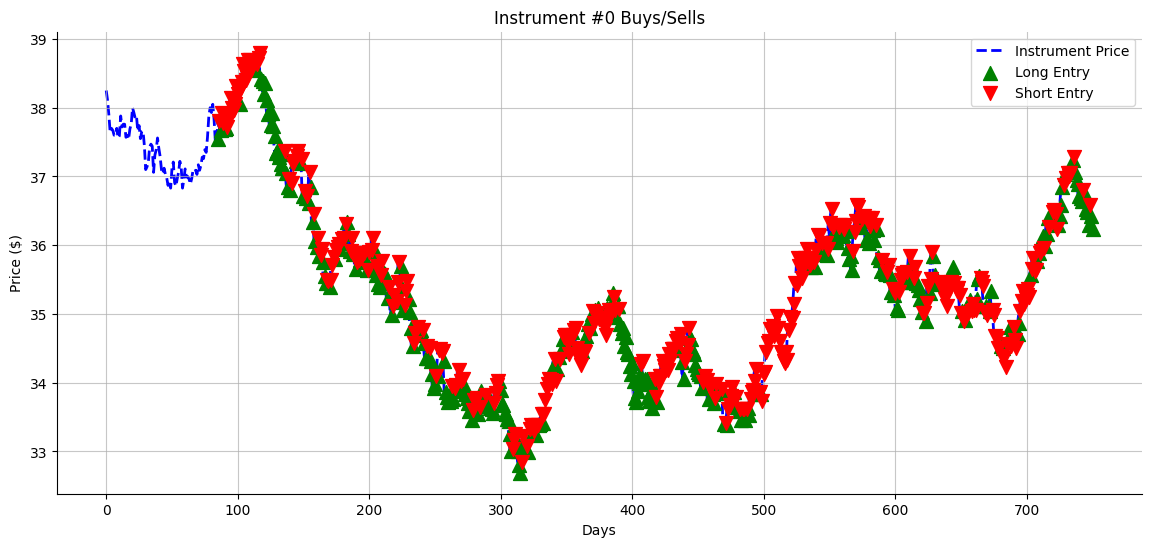

In [3]:
params = backtester.Params(
    strategy_function=getMyPosition,
    start_day=1,
    end_day=750,
    enable_commission=True,
    graphs=["cum-pnl", "sharpe-heat-map", "daily-pnl"]
)

bt = backtester.Backtester(params)
results = bt.run(start_day=1, end_day=750)
bt.show_dashboard(results, graphs=params.graphs)
bt.show_price_entries(results)